In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

# Antiplane slip example
In this example we will demonstrate how to use `bemcs` to compute quadratic polynomial coefficients that describe smooth slip across an arbitrary fault geometry in antiplane geometry. The steps we will follow are as follows:

1. Construct fault geometry and store it in `els`
2. Label nodes using `bemcs.label_nodes()` for open, 2-node overlapping edges and triple junctions
3. Use labelled nodes to construct an operator, $A$, to construct a matrix system: $A\cdot x = b$ where $b$ contains the boundary conditions (slip, displacement or tractions at center nodes)
4. Solve $A\dot x = b$ to get polynomial coefficients $x$, and predict displacements and stresses everywhere in the medium

First we need to construct a fault. To do that simply provide the end points of each fault segment as follows.

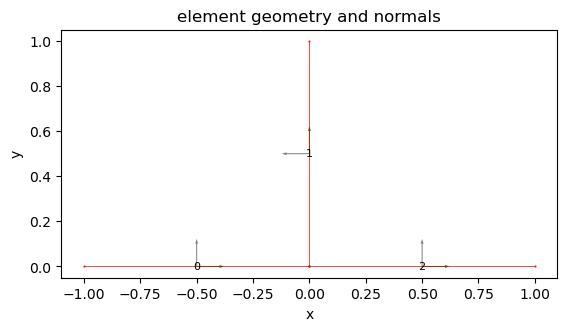

In [2]:
# Elastic parameter (shear modulus)
mu = 1.0
els = bemcs.initialize_els()

# setup a fault geometry
els.x1 = np.array([-1.0, 0.0, 0.0])
els.y1 = np.array([0.0, 0.0, 0.0])
els.x2 = np.array([0.0, 0.0, 1.0])
els.y2 = np.array([0.0, 1.0, 0.0])

"""els.x1 = np.array([-0.2, 0.0, 0.0])
els.y1 = np.array([1.0, 0.0, -0.5])
els.x2 = np.array([0.0, 0.0, 0.2])
els.y2 = np.array([0.0, -0.5, -1.5])
"""

slip_vector = np.array([1.0, 0.5, 1.0]) * 0.6

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

## Label nodes
Identify open nodes, 2-overlap nodes and triple junctions. In this case we don't have any triple junctions, but we have two 2-overlap nodes and two open nodes. In general, for a simply connected line source with $N$ segments, we should expect $N-1$ 2-overlap nodes and two open nodes.

In [3]:
stride = 3
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = n_els  # central node equations
N_o = len(index_open)  # open node equations
N_i = 2 * len(index_overlap)  # overlapping node equations
N_t = 3 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = stride * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[:, 0] = slip_vector

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

print(np.floor(np.abs(index_triple[0] / 3)))

matrix_system_o, matrix_system_i, matrix_system_t = (
    bemcs.construct_smoothoperator_antiplane(
        els, index_open, index_overlap, index_triple
    )
)

Number of open nodes = 3
: [array([0]), array([5]), array([8])]
Number of 2-overlap nodes = 0
: []
Number of triple junctions = 1
: [array([-3, -6,  2])]
[1. 2. 0.]


## Setup linear system of equations and solve for polynomial coefficients

In [4]:
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient_antiplane(
    els, flag="node"
)

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
# populate matrix_system for central nodes
matrix_system_c[:, :] = slip_mat[1::stride, :]

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# Solve for quadratic node coefficients (in local (s, n) coordinates)
quadcoefs = np.linalg.inv(matrix_system) @ BCvector
# quadcoefs = np.array([1, 1, 1, 0, 1, 0]).reshape(-1, 1)

# compute slip at nodes
xf = np.zeros(3 * n_els)
xf[0::3] = els.x1
xf[1::3] = els.x_centers
xf[2::3] = els.x2
xnodes, _, slipnodes = bemcs.get_slipvector_on_fault_antiplane(
    els, quadcoefs.flatten(), 100
)
plt.figure()
plt.plot(xnodes, slipnodes, ".")
plt.plot(xf, slip_mat @ quadcoefs, "o")
plt.xlabel("x")
plt.ylabel("slip")
plt.grid()
plt.show()
print(np.vstack((xf, slip_mat @ quadcoefs.flatten())).T)

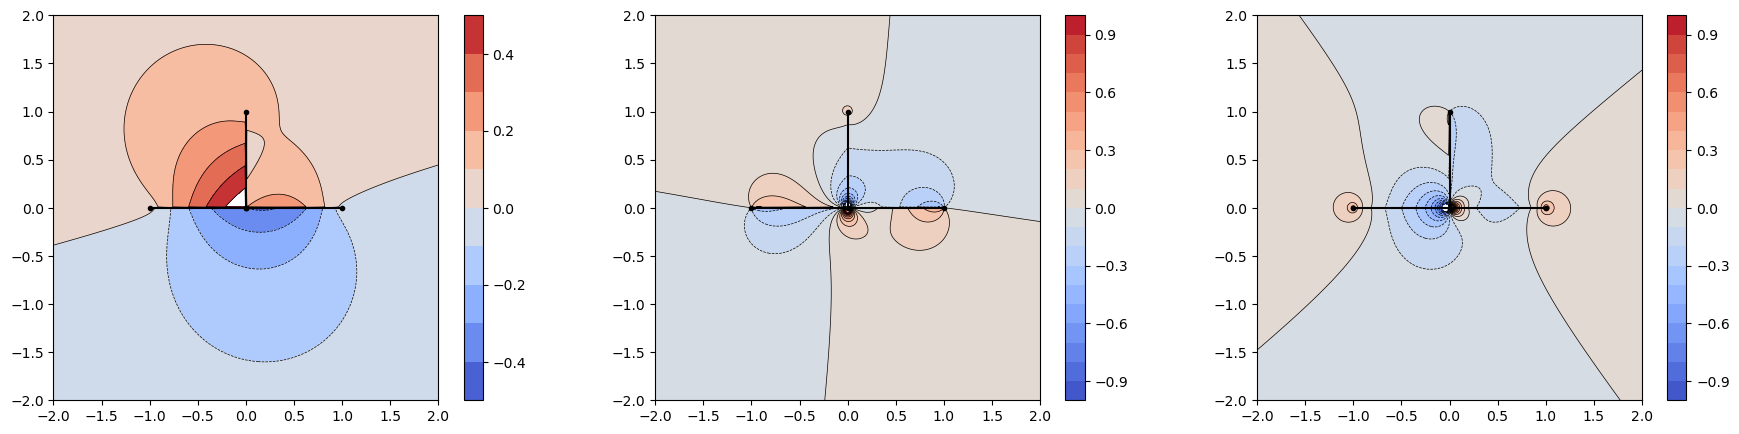

In [6]:
# # Observation points
# xo = np.linspace(-2, 2, 100).reshape(-1, 1)
# yo = np.zeros_like(xo) + 1e-6

nx_obs = 200
ny_obs = 200
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 2, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

# compute displacements and stress components
u = K_u @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(22, 5))
plt.subplot(1, 3, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 2)
toplot = sx.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
toplot = sy.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar()
plt.contour(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    colors="k",
    levels=levels,
    linewidths=0.5,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")

plt.gca().set_aspect("equal", adjustable="box")
plt.show()

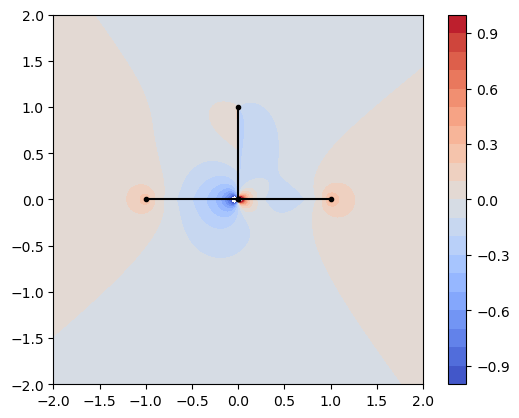

In [7]:
# compute traction kernels
els_plot = bemcs.initialize_els()
els_plot.x_normals = 0 * np.ones_like(xo).T
els_plot.y_normals = 1 * np.ones_like(xo).T

K_t = bemcs.get_traction_kernels_antiplane(els_plot, tuple([K_sx, K_sy]))
t = K_t @ quadcoefs

plt.figure()
toplot = t.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 21)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()